
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [42]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData['time'] //=8
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,387,152,172
125769,387,152,174
125770,387,167,180
125771,387,172,178


In [44]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [45]:
ALPHA = 1/2 #S -> E
BETA = 0.8 #E -> I 
GAMMA = 1/14 #I -> R 5

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

# Simulation

In [46]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initisaltion od Status Matrix, where everyone is susceptible
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(388, 242)


In [47]:
NUMOFPATIENTZERO = 1
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [48]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(set) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].add(node_j)
    edgesDictionaryWRTTime[time][node_j].add(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'set'>, {58: {62, 63}, 63: {58, 66, 62}, 59: {64}, 64: {59}, 66: {62, 63}, 85: {214, 190, 191}, 190: {85}, 214: {85, 191}, 102: {115}, 115: {102}, 191: {85, 214, 199}, 199: {191}, 143: {192}, 192: {143}, 188: {194, 134}, 194: {188, 134}, 62: {58, 66, 63}, 163: {172}, 172: {154, 163, 157}, 184: {186, 196, 198}, 186: {184}, 196: {184}, 36: {50, 51}, 51: {36}, 154: {176, 172, 156, 157}, 156: {154}, 17: {32, 41, 27, 39}, 39: {17}, 80: {87}, 87: {80}, 157: {154, 172}, 13: {32, 41, 16, 23, 27}, 32: {41, 13, 17, 23, 27}, 41: {32, 13, 17, 20, 23, 27}, 20: {41, 15}, 35: {24, 43, 15}, 43: {35}, 50: {36}, 88: {90}, 90: {88}, 152: {168}, 168: {152, 166}, 161: {164}, 164: {161}, 162: {173}, 173: {162}, 166: {168}, 23: {32, 16, 13, 41}, 27: {32, 17, 13, 41}, 15: {35, 20}, 24: {35}, 76: {79}, 79: {76}, 78: {83}, 83: {78}, 134: {194, 188}, 176: {154}, 12: {30, 31}, 30: {18, 12, 31}, 31: {18, 12, 30}, 16: {18, 13, 23}, 18: {16, 30, 31}, 198: {184}})


In [49]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

In [50]:
for t in range(tMax):
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED
    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  39  40  41  42  43  46  47  48  49  50  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  90  91  92  93  98  99 100 102
 103 104 108 109 111 112 113 114 115 116 117 118 119 121 122 123 124 125
 126 128 131 132 133 134 135 136 137 138 139 140 141 142 143 144 147 148
 149 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 170 171 172 173 174 175 176 177 178 179 180 182 183 184 185 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 207 208
 210 211 213 214 217 218 219 222 223 224 225 228 229 230 232 234 235 236
 237 238 239 240 241]


In [51]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    #print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
print(listPopulations.head())
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
     1  2  3  4
0  241  1  0  0
1  241  1  0  0
2  241  1  0  0
3  241  1  0  0
4  241  1  0  0


Text(0.5, 0, 'Period (in Days)')

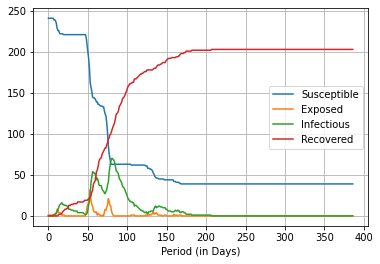

In [52]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot()
plt.legend()
plt.grid()
plt.xlabel("Period (in Days)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Period (in Days)')

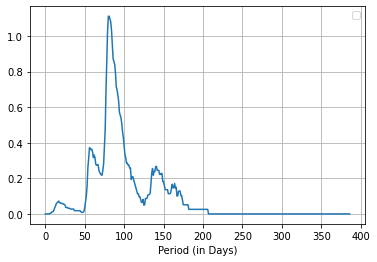

In [53]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()
plt.xlabel("Period (in Days)")

In [54]:
## A function that returns the end of pandemic if it ends before end of data or -1 otherwise
def endOfEpidemic(dfListPopulations):
    endDay = 0
    for row in dfListPopulations.values:
        if row[EXPOSED-1] !=0 or row[INFECTIOUS-1] != 0:
            endDay += 1
        else:
            break
    if endDay == listPopulations.shape[0]:
        return -1
    else:
        return endDay

print("End of Epidemic : ", endOfEpidemic(listPopulations))

End of Epidemic :  207


## Network Visualation using iGraph Package

In [58]:
# STATEDICT ={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}

TIME = 0
def networkGraphAtTimet(networkData, statusMatrix, time):
    query =  "time=={time}".format(time = time)
    numOfNodes = statusMatrix.shape[1]
    graph = ig.Graph(n=numOfNodes, edges=networkData.query(query)[['node-i','node-j']].values)
    graph.vs["state"] = statusMatrix[time]
    color_dict = {1: "lightblue", 2: "yellow", 3:"red", 4:"green"}
    graph.vs["color"] = [color_dict[state] for state in graph.vs["state"]]
    graph.vs["label"] = [node for node in range(numOfNodes)]
    graph.simplify(multiple=True)
    return graph

# Sequential plotting for animation
TMAX = 220
TSTEP = 1
for t in range(0, TMAX, TSTEP):
    img = ig.plot(networkGraphAtTimet(networkData, statusMatrix, t), vertex_label_color="black", vertex_label_size=8, vertex_size=14)
    img.save("img/" + str(t) + ".png")